In [1]:
import os
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader

from monai.config import print_config
from monai.transforms import \
    Compose, LoadPNG, AddChannel, ScaleIntensity, ToTensor, RandRotate, RandFlip, RandZoom, RepeatChannel
from monai.networks.nets import densenet121
from monai.metrics import compute_roc_auc

import pandas as pd
import random

import matplotlib.pyplot as plt
import datetime

import torchvision.models as models
import torch.nn as nn

#For GradCAM
import cv2
from torchvision.transforms import transforms
import torch.nn.functional as F
from torchvision.utils import make_grid, save_image
import PIL 
#For GuidedBP
from torch.nn import ReLU
from torch.autograd import Variable

In [2]:
# Normal Cohort read
working_directory = '/mnt/datasets/fastcovnet/'
data = pd.read_csv(os.path.join(working_directory,'filtered_cohort.csv'),"|")
columnToPredict = 'Case_type'
resolution = '224'

In [4]:
# jpg full path creation
data["jpg_full_path"] = data["path"].replace({'/dicoms/': '/jpg/'}, regex=True)+resolution +'/'+data["filename"].replace({'.dcm': '.jpg'}, regex=True)

# Classes to predict
class_names = sorted(data[columnToPredict].unique())
num_class = len(class_names)
data[columnToPredict].value_counts()

Case       4713
Control    3133
Name: Case_type, dtype: int64

In [5]:
image_files = [data[data[columnToPredict]==x].loc[:,"jpg_full_path"].tolist() for x in class_names]

image_file_list = []
image_label_list = []
for i, class_name in enumerate(class_names):
    image_file_list.extend(image_files[i])
    image_label_list.extend([i] * len(image_files[i]))   # Creates an array of 0 or 1 with a length of that category
num_total = len(image_label_list)     # Number of images

Text(0.5, 0, '3208 - Case')

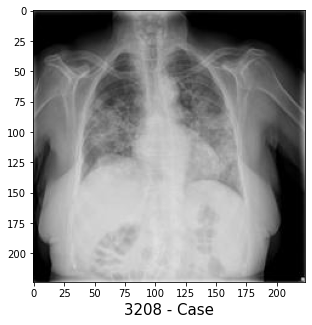

In [6]:
#Take and Show Sample from Dataset
fig, ax = plt.subplots(1,1, figsize=(5, 5))
k = random.randint(0, len(image_file_list))
im = Image.open(image_file_list[k])
arr = np.array(im)
ax.imshow(arr, cmap='gray', vmin=0, vmax=255)
ax.set_xlabel(str(k)+' - '+class_names[image_label_list[k]], fontsize=15)

In [7]:
intX, intY = [], []
for i in range(len(image_file_list)):
    intX.append(image_file_list[i])
    intY.append(image_label_list[i])

In [8]:
int_transforms = Compose([
    LoadPNG(image_only=True),
    AddChannel(),
    ScaleIntensity(),
    RepeatChannel(3),
    ToTensor()
])

In [9]:
class InterpretationDataset(Dataset):
    def __init__(self, image_files, labels, transforms):
        self.image_files = image_files
        self.labels = labels
        self.transforms = transforms

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        return self.transforms(self.image_files[index]), self.labels[index]

int_dataset = InterpretationDataset(intX, intY, int_transforms)
int_loader = DataLoader(int_dataset, batch_size=1, num_workers=1)

In [10]:
"""This notebook is implemented in the next-to-best saved ResNet model. The reason is that last minute changes were made in the model
 (change from 1 channel to 3 channel inputs and apply sigmod at the classifier), which were correct and slightly improved the model, 
 but we didn't have enought time to adjust the GBP, GradCAM and GuidedGradCAM to work with the last model """

device = torch.device("cuda:0")
savedmodel = torch.load('/home/belendlrio/2best_metric_ResNet_224.pth')
model = models.resnet152(pretrained=True)
model.fc = nn.Linear(in_features = 2048, out_features = num_class, bias = True)
model.load_state_dict(savedmodel["model"])

<All keys matched successfully>

<h1>INTERPRETATION<h1>

In [11]:
#Datetime of new experiment
x = datetime.datetime.now()
print(str(x))

2020-11-18 15:38:40.613970


In [12]:
#Directory for NewExperiment
if not os.path.exists('/home/belendlrio/InterpretationResults/'+'resnet'+ str(k)+' '+str(x)):
    os.makedirs('/home/belendlrio/InterpretationResults/'+'resnet'+ str(k)+' '+str(x))
interpretation_dir = '/home/belendlrio/InterpretationResults/'+'resnet'+ str(k)+' '+str(x)

#Get a data sample (n=1) from interpretation dataset.
interp_item = int_dataset[k]
#Get the image from the data sample
image_to_inter = interp_item[0]
#Add batch_size to feed it in GBP and GradCAM
b_image_to_inter = torch.unsqueeze(image_to_inter,0)

In [13]:
#Set model in validation mode and get a prediction.
model.to(device)
model.eval()
y_true = list()
y_pred = list()
with torch.no_grad():
    int_input = interp_item
    int_image, int_label = int_input[0].to(device), int_input[1]
    int_to_model = torch.unsqueeze(int_image,0)
    pred = model(int_to_model).argmax(dim=1)
    y_true.append(int_label)
    y_pred.append(pred.item())

Text(0.5, 0, '3208 - Case - Case')

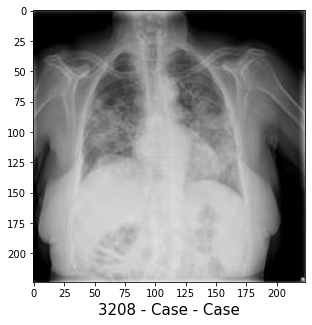

In [14]:
#Show input and predicton from model 
fig, ax = plt.subplots(1,1, figsize=(5, 5))
im = Image.open(image_file_list[k])
arr = np.array(im)
ax.imshow(arr, cmap='gray', vmin=0, vmax=255)
ax.set_xlabel(str(k)+' - '+class_names[y_true[0]]+' - '+class_names[y_pred[0]], fontsize=15)

<h1>Guided Backpropagation<h1>

<h3>Functions<h3>

In [15]:
class GuidedBackprop():
    """
       Produces gradients generated with guided back propagation from the given image
    """
    def __init__(self, model):
        self.model = model
        self.gradients = None
        # Put model in evaluation mode
        self.model.eval()
        self.update_relus()
        self.hook_layers()

    def hook_layers(self):
        def hook_function(module, grad_in, grad_out):
            self.gradients = grad_in[0]

        # Register hook to the first layer
        first_layer = list(self.model.children())[0] ##We will use the first layer
        first_layer.register_backward_hook(hook_function)

    def update_relus(self):
        """
            Updates relu activation functions so that it only returns positive gradients
        """
        def relu_hook_function(module, grad_in, grad_out):
            """
            If there is a negative gradient, changes it to zero
            """
            if isinstance(module, ReLU):
                return (torch.clamp(grad_in[0], min=0.0),)
        # Loop through layers, hook up ReLUs with relu_hook_function
        for module in self.model.modules():
            if isinstance(module, ReLU):
                module.register_backward_hook(relu_hook_function)
                
    def reformat(self, gradients_as_arr,input_image): 
        ##Needed to format gradients if child7(Layer4-Conv3) is chosen [2048,7,7] to [1,1,224,224]
        b, c, h, w = input_image.size()
        b, k, u, v = self.gradients.size() #On7thChild (Layer4-Conv3) [1,2048,7,7]
        
        alpha = self.gradients.view(b, k, -1).mean(2) #On7thChild (Layer4-Conv3) [1,2048]
        #alpha = F.relu(gradients.view(b, k, -1)).mean(2)
        weights = alpha.view(b, k, 1, 1) ###On7thChild (Layer4-Conv3) [1, 2048, 1, 1]

        saliency_map = (weights).sum(1, keepdim=True) #On7thChild (Layer4-Conv3) [1,1,1,1]
        saliency_map = F.interpolate(saliency_map, size=(h, w), mode='bilinear', align_corners=False) #On7thChild (Layer4-Conv3) [1,1,224,224]
        saliency_map_min, saliency_map_max = saliency_map.min(), saliency_map.max()
        saliency_map = (saliency_map - saliency_map_min).div(saliency_map_max - saliency_map_min).data #On7thChild (Layer4-Conv3) [1,1,224,224]
        return saliency_map
    
    def generate_gradients(self, input_image, target_class):
        # Forward pass
        model_output = self.model(input_image)
        # Zero gradients
        self.model.zero_grad()
        # Target for backprop
        one_hot_output = torch.FloatTensor(1, model_output.size()[-1]).zero_()
        one_hot_output[0][target_class] = 1
        # Backward pass
        model_output.backward(gradient=one_hot_output)
        # Convert Pytorch variable to numpy array
        # [0] to get rid of the first channel (1,3,224,224)
        gradients_as_arr = self.gradients.data.numpy()[0]
        #gradients_as_tensor = torch.from_numpy(gradients_as_arr)
        return gradients_as_arr

In [16]:
def convert_to_grayscale(im_as_arr):
    """
        Converts 3d image to grayscale
    Args:
        im_as_arr (numpy arr): RGB image with shape (D,W,H)
    returns:
        grayscale_im (numpy_arr): Grayscale image with shape (1,W,D)
    """
    grayscale_im = np.sum(np.abs(im_as_arr), axis=0)
    im_max = np.percentile(grayscale_im, 99)
    im_min = np.min(grayscale_im)
    grayscale_im = (np.clip((grayscale_im - im_min) / (im_max - im_min), 0, 1))
    grayscale_im = np.expand_dims(grayscale_im, axis=0)
    return grayscale_im

In [17]:
def get_positive_negative_saliency(gradient):
    """
        Generates positive and negative saliency maps based on the gradient
    Args:
        gradient (numpy arr): Gradient of the operation to visualize
    returns:
        pos_saliency ( )
    """
    pos_saliency = (np.maximum(0, gradient) / gradient.max())
    neg_saliency = (np.maximum(0, -gradient) / -gradient.min())
    return pos_saliency, neg_saliency


In [18]:
def save_gradient_images(gradient, file_name):
    """
        Exports the original gradient image
    Args:
        gradient (np arr): Numpy array of the gradient with shape (3, 224, 224)
        file_name (str): File name to be exported
    """
    # Normalize
    gradient = gradient - gradient.min()
    gradient /= gradient.max()
        
    # Save image
    if not os.path.exists(interpretation_dir+'/GBoutputs'):
        os.makedirs(interpretation_dir+'/GBoutputs')
    gb_output_dir = interpretation_dir+'/GBoutputs'
    
    path_to_file = os.path.join(gb_output_dir, file_name + '.jpg')
    save_image_v(gradient, path_to_file)

In [19]:
def format_np_output(np_arr):
    """
        Converts all the outputs to the same format which is 3xWxH
        with using sucecssive if clauses.
    Args:
        im_as_arr (Numpy array): Matrix of shape 1xWxH or WxH or 3xWxH
    """
    # Phase/Case 1: The np arr only has 2 dimensions
    # Result: Add a dimension at the beginning
    if len(np_arr.shape) == 2:
        np_arr = np.expand_dims(np_arr, axis=0)
    # Phase/Case 2: Np arr has only 1 channel (assuming first dim is channel)
    # Result: Repeat first channel and convert 1xWxH to 3xWxH
    if np_arr.shape[0] == 1:
        np_arr = np.repeat(np_arr, 3, axis=0)
    # Phase/Case 3: Np arr is of shape 3xWxH
    # Result: Convert it to WxHx3 in order to make it saveable by PIL
    if np_arr.shape[0] == 3:
        np_arr = np_arr.transpose(1, 2, 0)
    # Phase/Case 4: NP arr is normalized between 0-1
    # Result: Multiply with 255 and change type to make it saveable by PIL
    if np.max(np_arr) <= 1:
        np_arr = (np_arr*255).astype(np.uint8)
    return np_arr

In [20]:
def save_image_v(im, path):
    """
        Saves a numpy matrix or PIL image as an image
    Args:
        im_as_arr (Numpy array): Matrix of shape DxWxH
        path (str): Path to the image
    """
    if isinstance(im, (np.ndarray, np.generic)):
        im = format_np_output(im)
        im = cv2.resize(im,(224,224))
        #im = Image.fromarray((x * 255).astype(np.uint8))
        im = Image.fromarray(im)
    im.save(path)

In [21]:
#If unsure of the child that you want to use
def child_counter(model):
    child_counter = 0
    for child in model.children():
        print(" child", child_counter, "is -")
        print(child)
        child_counter += 1

In [22]:
def imagetensor_from_gradients(gradient):
    # Normalize
    gradient = gradient - gradient.min()
    gradient /= gradient.max()
    gradient = torch.from_numpy(gradient)
    return gradient

In [23]:
def create_composed_GBP_grid(guided_grads, grayscale_guided_grads, pos_sal, neg_sal):
    #Directory and name
    gbp_output_dir = interpretation_dir+'/GBoutputs'
    output_name = str(k)+' - '+class_names[y_true[0]]+' - '+class_names[y_pred[0]]+' - GRID'
    #get tensors from gradients
    guided_grads = imagetensor_from_gradients(guided_grads)
    grayscale_guided_grads = imagetensor_from_gradients(grayscale_guided_grads).repeat(3,1,1)
    pos_sal = imagetensor_from_gradients(pos_sal)
    neg_sal = imagetensor_from_gradients(neg_sal)
    #make grid
    guided_backprop = []
    guided_backprop.append(torch.stack([image_to_inter, guided_grads, grayscale_guided_grads, pos_sal, neg_sal], 0))
    guided_backprop = make_grid(torch.cat(guided_backprop, 0), nrow=5)
    #save grid
    output_path_gbp = os.path.join(gbp_output_dir, output_name)
    save_image(guided_backprop, output_path_gbp, format='png')
    return output_path_gbp

<h3>Perform GuidedBackpropagation of previously sampled input on model<h3>

In [24]:
#We convert the image input to the model [1,1,224,224] to Variant so that it stores gradients. 
im_as_var = Variable(b_image_to_inter, requires_grad=True)

In [25]:
prep_img = im_as_var #image
target_class = interp_item[1] #Label
file_name_to_export =str(k)+' - '+class_names[y_true[0]]+' - '+class_names[y_pred[0]]
pretrained_model = model.cpu()

In [26]:
# Guided backprop
GBP = GuidedBackprop(pretrained_model)
# Get gradients
guided_grads = GBP.generate_gradients(prep_img, target_class)
#If Child7 used instead of Child0
#guided_grads = GBP.reformat(guided_grads)
# Save colored gradients
save_gradient_images(guided_grads, file_name_to_export + '_Guided_BP_color')
# Convert to grayscale
grayscale_guided_grads = convert_to_grayscale(guided_grads)
# Save grayscale gradients
save_gradient_images(grayscale_guided_grads, file_name_to_export + '_Guided_BP_gray')
# Positive and negative saliency maps
pos_sal, neg_sal = get_positive_negative_saliency(guided_grads)
save_gradient_images(pos_sal, file_name_to_export + '_pos_sal')
save_gradient_images(neg_sal, file_name_to_export + '_neg_sal')
print('Guided backprop completed')

Guided backprop completed


In [27]:
GBP_grid = create_composed_GBP_grid(guided_grads, grayscale_guided_grads, pos_sal, neg_sal)

Text(0.5, 0, '3208 - Case - Case')

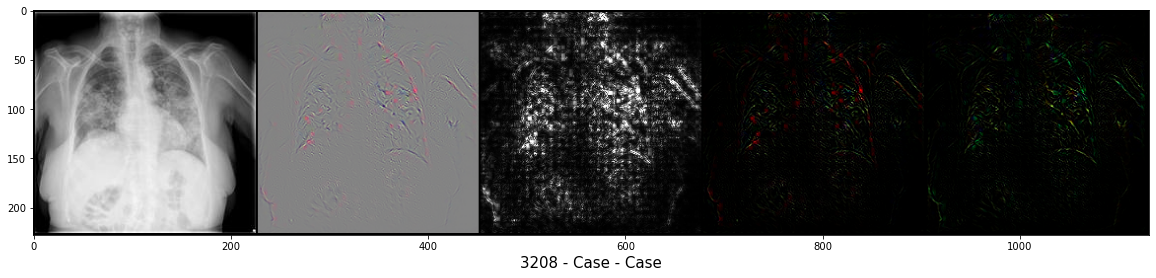

In [28]:
#PIL.Image.open(GBP_grid)
fig, ax = plt.subplots(1,1, figsize=(20, 80))
im = Image.open(GBP_grid)
arr = np.array(im)
ax.imshow(arr, cmap='gray', vmin=0, vmax=255)
ax.set_xlabel(str(k)+' - '+class_names[y_true[0]]+' - '+class_names[y_pred[0]], fontsize=15)

<h1>GradCAM<h1>
<h3>Functions<h3>

In [29]:
#Formats the chosen layer to be fed to GradCAM.
def find_resnet_layer(arch, target_layer_name):
    if 'layer' in target_layer_name:
        hierarchy = target_layer_name.split('_')
        layer_num = int(hierarchy[0].lstrip('layer'))
        if layer_num == 1:
            target_layer = arch.layer1
        elif layer_num == 2:
            target_layer = arch.layer2
        elif layer_num == 3:
            target_layer = arch.layer3
        elif layer_num == 4:
            target_layer = arch.layer4
        else:
            raise ValueError('unknown layer : {}'.format(target_layer_name))

        if len(hierarchy) >= 2:
            bottleneck_num = int(hierarchy[1].lower().lstrip('bottleneck').lstrip('basicblock'))
            target_layer = target_layer[bottleneck_num]

        if len(hierarchy) >= 3:
            target_layer = target_layer._modules[hierarchy[2]]
                
        if len(hierarchy) == 4:
            target_layer = target_layer._modules[hierarchy[3]]

    else:
        target_layer = arch._modules[target_layer_name]

    return target_layer

In [30]:
class GradCAM(object):
    """Calculate GradCAM salinecy map.
    A simple example:
        # initialize a model, model_dict and gradcam
        model.eval()
        model_dict = dict(model_type='resnet', arch=resnet, layer_name='layer4', input_size=(224, 224))
        gradcam = GradCAM(model_dict)
        # get an image from dataset and apply validation transforms
        # get a GradCAM saliency map on the predicted class or the target class index.
        mask, logit = gradcam(input_img, class_idx=None or target_class)
        # make heatmap from mask and synthesize saliency map using heatmap and img
        heatmap, cam_result = visualize_cam(mask, img)
    Args:
        model_dict (dict): a dictionary that contains 'model_type', 'arch', layer_name', 'input_size'(optional) as keys.
        verbose (bool): whether to print output size of the saliency map givien 'layer_name' and 'input_size' in model_dict.
    """
    def __init__(self, model_dict, verbose=False):
        model_type = model_dict['type']
        layer_name = model_dict['layer_name']
        self.model_arch = model_dict['arch']

        self.gradients = dict()
        self.activations = dict()
        def backward_hook(module, grad_input, grad_output):
            self.gradients['value'] = grad_output[0]
            return None
        def forward_hook(module, input, output):
            self.activations['value'] = output
            return None

        if 'resnet' in model_type.lower():
            target_layer = find_resnet_layer(self.model_arch, layer_name)
        elif 'densenet' in model_type.lower():
            target_layer = find_densenet_layer(self.model_arch, layer_name)

        target_layer.register_forward_hook(forward_hook)
        target_layer.register_backward_hook(backward_hook)

        if verbose:
            try:
                input_size = model_dict['input_size']
            except KeyError:
                print("please specify size of input image in model_dict. e.g. {'input_size':(224, 224)}")
                pass
            else:
                device = 'cuda' if next(self.model_arch.parameters()).is_cuda else 'cpu'
                self.model_arch(torch.zeros(1, 3, *(input_size), device=device))
                print('saliency_map size :', self.activations['value'].shape[2:])


    def forward(self, input, class_idx=None, retain_graph=False):
        """
        Args:
            input: input image with shape of (1, 3, H, W)
            class_idx (int): class index for calculating GradCAM.
                    If not specified, the class index that makes the highest model prediction score will be used.
        Return:
            mask: saliency map of the same spatial dimension with input
            logit: model output
        """
        b, c, h, w = input.size()

        logit = self.model_arch(input)
        if class_idx is None:
            score = logit[:, logit.max(1)[-1]].squeeze()
        else:
            score = logit[:, class_idx].squeeze()

        self.model_arch.zero_grad()
        score.backward(retain_graph=retain_graph)
        gradients = self.gradients['value']
        activations = self.activations['value']
        b, k, u, v = gradients.size()

        alpha = gradients.view(b, k, -1).mean(2)
        #alpha = F.relu(gradients.view(b, k, -1)).mean(2)
        weights = alpha.view(b, k, 1, 1)

        saliency_map = (weights*activations).sum(1, keepdim=True)
        saliency_map = F.relu(saliency_map)
        saliency_map = F.interpolate(saliency_map, size=(h, w), mode='bilinear', align_corners=False)
        saliency_map_min, saliency_map_max = saliency_map.min(), saliency_map.max()
        saliency_map = (saliency_map - saliency_map_min).div(saliency_map_max - saliency_map_min).data

        return saliency_map, logit

    def __call__(self, input, class_idx=None, retain_graph=False):
        return self.forward(input, class_idx, retain_graph)

class GradCAMpp(GradCAM):
    """Calculate GradCAM++ saliency map.
    A simple example:
        # initialize a model, model_dict and gradcampp
        resnet = torchvision.models.resnet101(pretrained=True)
        resnet.eval()
        model_dict = dict(model_type='resnet', arch=resnet, layer_name='layer4', input_size=(224, 224))
        gradcampp = GradCAMpp(model_dict)
        # get an image from dataset and apply validation transforms
        # get a GradCAM saliency map on the predicted class or the target class index.
        mask, logit = gradcam(input_img, class_idx=None or target_class)
        # make heatmap from mask and synthesize saliency map using heatmap and img
        heatmap, cam_result = visualize_cam(mask, img)
    Args:
        model_dict (dict): a dictionary that contains 'model_type', 'arch', layer_name', 'input_size'(optional) as keys.
        verbose (bool): whether to print output size of the saliency map givien 'layer_name' and 'input_size' in model_dict.
    """
    def __init__(self, model_dict, verbose=False):
        super(GradCAMpp, self).__init__(model_dict, verbose)

    def forward(self, input, class_idx=None, retain_graph=False):
        """
        Args:
            input: input image with shape of (1, 3, H, W)
            class_idx (int): class index for calculating GradCAM.
                    If not specified, the class index that makes the highest model prediction score will be used.
        Return:
            mask: saliency map of the same spatial dimension with input
            logit: model output
        """
        b, c, h, w = input.size()

        logit = self.model_arch(input)
        if class_idx is None:
            score = logit[:, logit.max(1)[-1]].squeeze()
        else:
            score = logit[:, class_idx].squeeze() 
            
        self.model_arch.zero_grad()
        score.backward(retain_graph=retain_graph)
        gradients = self.gradients['value'] # dS/dA
        activations = self.activations['value'] # A
        b, k, u, v = gradients.size()

        alpha_num = gradients.pow(2)
        alpha_denom = gradients.pow(2).mul(2) + \
                activations.mul(gradients.pow(3)).view(b, k, u*v).sum(-1, keepdim=True).view(b, k, 1, 1)
        alpha_denom = torch.where(alpha_denom != 0.0, alpha_denom, torch.ones_like(alpha_denom))

        alpha = alpha_num.div(alpha_denom+1e-7)
        positive_gradients = F.relu(score.exp()*gradients) # ReLU(dY/dA) == ReLU(exp(S)*dS/dA))
        weights = (alpha*positive_gradients).view(b, k, u*v).sum(-1).view(b, k, 1, 1)

        saliency_map = (weights*activations).sum(1, keepdim=True)
        saliency_map = F.relu(saliency_map)
        saliency_map = F.interpolate(saliency_map, size=(224, 224), mode='bilinear', align_corners=False)
        saliency_map_min, saliency_map_max = saliency_map.min(), saliency_map.max()
        saliency_map = (saliency_map-saliency_map_min).div(saliency_map_max-saliency_map_min).data

        return saliency_map, logit

In [31]:
def visualize_cam(mask, img):
    """Make heatmap from mask and synthesize GradCAM result image using heatmap and img.
    Args:
        mask (torch.tensor): mask shape of (1, 1, H, W) and each element has value in range [0, 1]
        img (torch.tensor): img shape of (1, 3, H, W) and each pixel value is in range [0, 1]
        
    Return:
        heatmap (torch.tensor): heatmap img shape of (3, H, W)
        result (torch.tensor): synthesized GradCAM result of same shape with heatmap.
    """
    heatmap = cv2.applyColorMap(np.uint8(255 * mask.squeeze()), cv2.COLORMAP_JET)
    heatmap = torch.from_numpy(heatmap).permute(2, 0, 1).float().div(255)
    b, g, r = heatmap.split(1)
    heatmap = torch.cat([r, g, b])
    
    result = heatmap+img.cpu()
    result = result.div(result.max()).squeeze()
    
    return heatmap, result

In [32]:
def save_GradCAM_grid(gc_grid):
    #Directory and name
    GradCAM_output_dir = interpretation_dir+'/GradCAMoutputs'
    os.makedirs(GradCAM_output_dir, exist_ok=True)
    output_name = str(k)+' - '+class_names[y_true[0]]+' - '+class_names[y_pred[0]]
    
    #save grid
    output_path_GradCAM = os.path.join(GradCAM_output_dir, output_name)
    save_image(gc_grid, output_path_GradCAM, format='png')
    return output_path_GradCAM

<h3>Perform GradCAM of previously sampled input on model<h3>

In [33]:
resnet = model.eval()
cam_dict = dict()
resnet_model_dict = dict(type='resnet', arch=resnet, layer_name='layer4_bottleneck2_bn3', input_size=(224, 224))
resnet_gradcam = GradCAM(resnet_model_dict, True)
resnet_gradcampp = GradCAMpp(resnet_model_dict, True)
cam_dict['resnet'] = [resnet_gradcam, resnet_gradcampp]

saliency_map size : torch.Size([7, 7])
saliency_map size : torch.Size([7, 7])


In [34]:
images = []
for gradcam, gradcam_pp in cam_dict.values():
    mask, _ = gradcam(b_image_to_inter)
    heatmap, result = visualize_cam(mask, image_to_inter)

    mask_pp, _ = gradcam_pp(b_image_to_inter)
    heatmap_pp, result_pp = visualize_cam(mask_pp, image_to_inter)
    
    images.append(torch.stack([image_to_inter, heatmap, heatmap_pp, result, result_pp], 0))
images = make_grid(torch.cat(images, 0), nrow=5)

In [35]:
grad_cam_grid = save_GradCAM_grid(images)


Text(0.5, 0, '3208 - Case - Case')

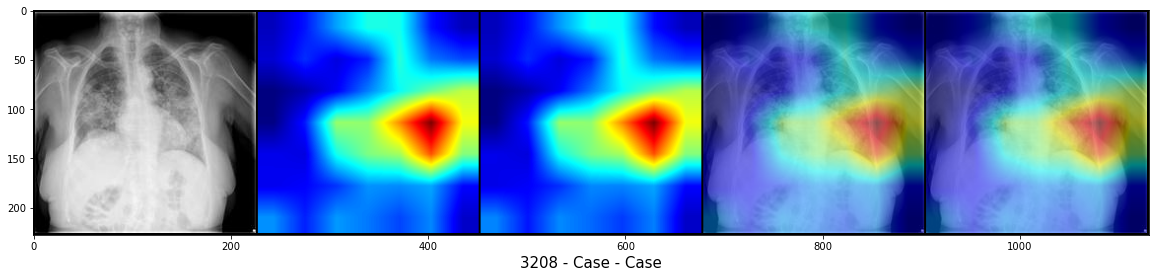

In [36]:
#PIL.Image.open(grad_cam_grid)
fig, ax = plt.subplots(1,1, figsize=(20, 80))
im = Image.open(grad_cam_grid)
arr = np.array(im)
ax.imshow(arr, cmap='gray', vmin=0, vmax=255)
ax.set_xlabel(str(k)+' - '+class_names[y_true[0]]+' - '+class_names[y_pred[0]], fontsize=15)

<h1>Guided Grad CAM<h1>

<h3>Functions<h3>

In [37]:
def guided_grad_cam(grad_cam_mask, guided_backprop_mask):
    """
        Guided grad cam is just pointwise multiplication of cam mask and guided backprop mask
    Args:
        grad_cam_mask (np_arr): Class activation map mask
        guided_backprop_mask (np_arr):Guided backprop mask
    """
    ##For feedeng the GradCam heatmap to the GuidedBackProp function it has to be converted to numpy array.
    grad_cam_mask = grad_cam_mask.numpy()
    
    cam_gb = np.multiply(grad_cam_mask, guided_backprop_mask)
    return cam_gb

In [38]:
def save_guidedgradcam_images(gradient, file_name):
    """
        Exports the original gradient image
    Args:
        gradient (np arr): Numpy array of the gradient with shape (3, 224, 224)
        file_name (str): File name to be exported
    """
    # Normalize
    gradient = gradient - gradient.min()
    gradient /= gradient.max()
        
    # Save image
    if not os.path.exists(interpretation_dir+'/GuidedGradCAMoutputs'):
        os.makedirs(interpretation_dir+'/GuidedGradCAMoutputs')
    ggc_output_dir = interpretation_dir+'/GuidedGradCAMoutputs'
    
    path_to_file = os.path.join(ggc_output_dir, file_name + '.jpg')
    save_image_v(gradient, path_to_file)

In [39]:
def create_combined_interpretation_grid(rx, gb, gradcam, cam_gb):
    #Directory and name
    ggc_output_dir = interpretation_dir+'/GuidedGradCAMoutputs'
    output_name = str(k)+' - '+class_names[y_true[0]]+' - '+class_names[y_pred[0]]+' - Combined'
    
    #format
    #rx = rx.repeat(3,1,1)
    gb = imagetensor_from_gradients(gb)
    #gb = gb.repeat(3,1,1)
    cam_gb = imagetensor_from_gradients(cam_gb)

    #make grid
    guided_gradcam = []
    guided_gradcam.append(torch.stack([rx, gb, gradcam, cam_gb], 0))
    guided_gradcam = make_grid(torch.cat(guided_gradcam, 0), nrow=4)
    #save grid
    output_path_ggc = os.path.join(ggc_output_dir, output_name)
    save_image(guided_gradcam, output_path_ggc, format='png')
    return output_path_ggc

<h3>Perform GuidedGradCAM of previously sampled input on model<h3>

In [40]:
# Guided Grad cam
cam_gb = guided_grad_cam(heatmap_pp, guided_grads)
save_guidedgradcam_images(cam_gb, file_name_to_export + '_GGrad_Cam')
grayscale_cam_gb = convert_to_grayscale(cam_gb)
save_guidedgradcam_images(grayscale_cam_gb, file_name_to_export + '_GGrad_Cam_gray')
print('Guided grad cam completed')

Guided grad cam completed


In [41]:
combined_interpretation = create_combined_interpretation_grid(image_to_inter, guided_grads, result_pp, cam_gb)

Text(0.5, 0, '3208 - Case - Case')

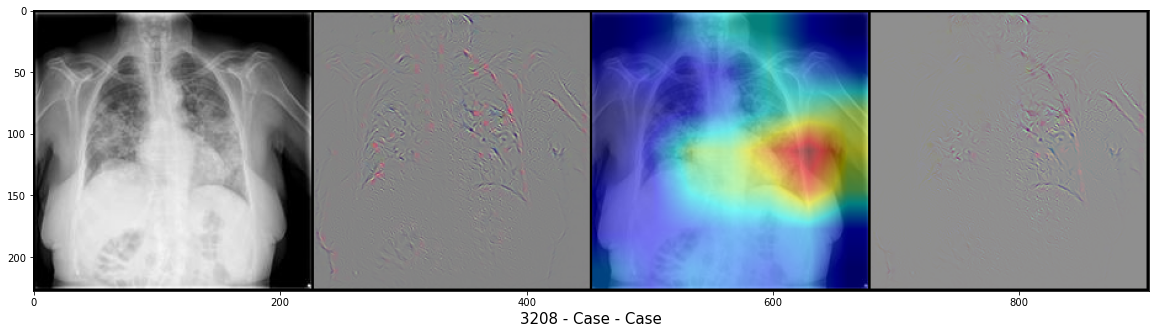

In [42]:
fig, ax = plt.subplots(1,1, figsize=(20, 80))
im = Image.open(combined_interpretation)
arr = np.array(im)
ax.imshow(arr, cmap='gray', vmin=0, vmax=255)
ax.set_xlabel(str(k)+' - '+class_names[y_true[0]]+' - '+class_names[y_pred[0]], fontsize=15)